In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from nemo import evaluate_nemo
import util
from topology import get_lognorm_hist
import topology
from util import evaluate
import pandas as pd
import random
from nemo import NemoSolver
import os

#### Topology Setup

In [2]:
# Specify the directory path
directory_path = 'datasets/RIPEAtlas/02072023/coords/'

# Iterate over all files in the directory
coord_dict = {}
for filename in os.listdir(directory_path):
    # Check if it's a file (not a directory)
    file = os.path.join(directory_path, filename)
    if os.path.isfile(file):
        df = topology.coords_ripe_atlas(file)
        # df["x"] = df["x"] - df["x"].mean()
        # df["y"] = df["y"] - df["y"].mean()
        
        df['latency'] = list(zip(df.x, df.y))
        df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - df.loc[0, ["x", "y"]].to_numpy()))
        f = filename.replace(".csv", "")
        f = int(f.replace("time-", ""))
        coord_dict[f] = df
        
coord_list = []
coord_mean = coord_dict[0][["x", "y"]].copy()
for i in sorted(coord_dict.keys()):
    coord_list.append(coord_dict[i])
    if i > 0:
        coord_mean["x"] += coord_dict[i]["x"]
        coord_mean["y"] += coord_dict[i]["y"]
coord_mean["x"] = coord_mean["x"] / len(coord_dict)
coord_mean["y"] = coord_mean["y"] / len(coord_dict)
coord_mean['latency'] = list(zip(coord_mean.x, coord_mean.y))
coord_mean['latency'] = coord_mean['latency'].apply(lambda x: np.linalg.norm(x - coord_mean.loc[0, ["x", "y"]].to_numpy()))

t_label = 0
coords_df = coord_dict[t_label]
s_dict = {t_label: coord_mean}
avg = 50
c_capacity = 50
seed = 10
H, bins = get_lognorm_hist()

device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(s_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=10, kmax=30, kseed=seed)
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
num_clusters = prim_df["cluster"].nunique() - 1
prim_df

Creating df for 0
Optimal k is 10
Done


,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1
0,308.494393,272.860026,0.000000,coordinator,398161,0,50,50,50,50,50,50,50,50,50,50,50,50,-1,1
1,316.976824,275.994535,9.043051,worker,398161,7,50,51,57,54,61,54,51,58,39,47,48,79,1,1
2,282.361038,258.647238,29.748203,worker,398161,2,50,52,55,46,58,65,82,30,95,53,14,4,1,1
3,306.501880,265.083892,8.027351,worker,398161,1,50,51,54,58,51,45,82,55,63,61,24,45,1,1
4,298.626985,272.848666,9.867415,worker,398161,25,50,51,46,50,46,43,50,69,48,19,38,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,306.716136,272.192946,1.899262,worker,398161,3,50,52,54,59,48,54,35,43,30,21,11,75,1,1
627,576.843206,381.661311,289.566581,worker,398161,14,50,48,49,50,42,68,39,32,27,23,141,4,7,1
628,435.369979,402.392926,181.317915,worker,398161,1,50,50,49,50,58,38,36,73,36,57,16,67,2,1
629,601.380349,374.773278,310.110455,worker,398161,1,50,51,54,51,55,50,82,50,71,25,35,27,7,1


In [3]:
coord_mean

,x,y,latency
0,308.494393,272.860026,0.000000
1,316.976824,275.994535,9.043051
2,282.361038,258.647238,29.748203
3,306.501880,265.083892,8.027351
4,298.626985,272.848666,9.867415
...,...,...,...
626,306.716136,272.192946,1.899262
627,576.843206,381.661311,289.566581
628,435.369979,402.392926,181.317915
629,601.380349,374.773278,310.110455


In [17]:
coord_dict[0]

,x,y,latency
0,-75.830277,52.683942,0.000000
1,-42.265554,59.965194,34.345411
2,-68.493981,9.120721,44.176640
3,-99.443849,25.313260,36.149067
4,-94.569935,-10.751235,66.145268
...,...,...,...
626,-129.978419,32.805344,57.681712
627,184.342454,203.354003,300.651489
628,-11.243729,216.694522,176.269375
629,178.467782,231.397961,310.815385


In [4]:
coord_dict.keys()

dict_keys([16, 8, 0, 2, 18, 22, 14, 4, 11, 21, 20, 1, 3, 9, 17, 13, 15, 5, 12, 19, 10, 23, 6, 7])

In [5]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 4444 Available: 31550


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

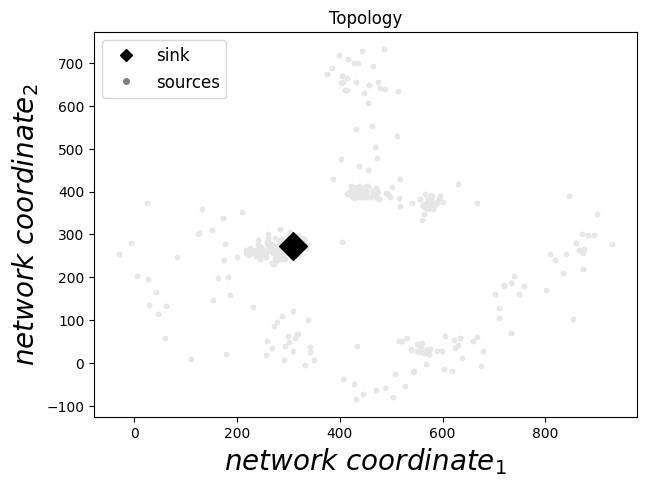

In [6]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, scale_fac=0.1)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")

plt.show()

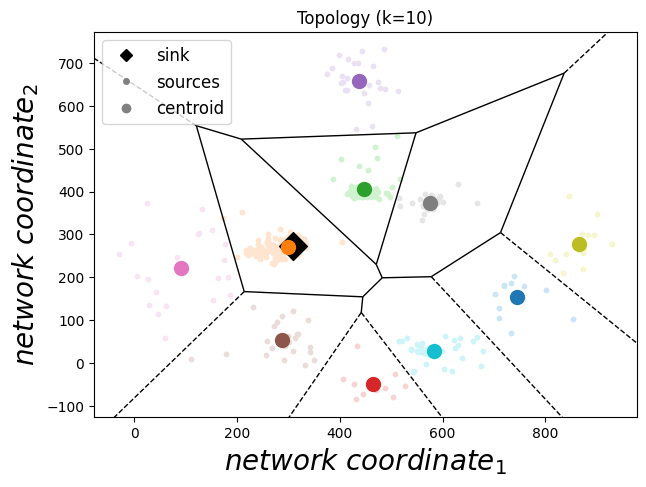

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.1,
                         plot_voronoi=True, plot_centroid=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_grouped.svg", bbox_inches="tight")

plt.show()

## Comparison of Latencies

In [36]:
param_dict = {
    "weight_1": {"merge_factor": 0.2, "step_size": 0.2},
    "weight_2": {"merge_factor": 0.9, "step_size": 0.2},
    "weight": {"merge_factor": 0.4, "step_size": 0.4},
}

In [37]:
df_rtt = pd.read_csv("datasets/RIPEAtlas/02072023/rtt_matrix/time-0.csv", sep=",")
df_rtt.columns = range(0, len(df_rtt.columns))
df_rtt

,0,1,2,3,4,5,6,7,8,9,...,621,622,623,624,625,626,627,628,629,630
0,0,20,58,37,38,62,394,392,175,31,...,22,272,33,175,32,33,289,172,321,44
1,20,0,41,33,37,43,337,372,182,20,...,4,257,33,153,36,21,408,172,289,4
2,58,41,0,9,48,58,536,413,259,44,...,53,328,24,223,10,42,308,218,375,49
3,37,33,9,0,41,58,506,408,187,18,...,37,288,10,198,1,30,302,193,294,36
4,38,37,48,41,0,65,406,399,333,26,...,41,277,55,225,47,34,286,269,336,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,33,21,42,30,34,56,430,384,195,23,...,21,289,20,193,37,0,372,185,339,21
627,289,408,308,302,286,304,403,635,143,314,...,274,41,448,142,736,372,0,126,34,275
628,172,172,218,193,269,194,288,514,43,185,...,177,131,186,24,199,185,126,0,167,177
629,321,289,375,294,336,348,433,653,132,327,...,316,8,364,158,356,339,34,167,0,302


In [38]:
ndf = prim_df.copy()
i = 0
slot_col = "capacity_100"
weight_col = "weight_1"

ndf["x"] = coord_list[i]["x"]
ndf["y"] = coord_list[i]["y"]
ndf["latency"] = coord_list[i]["latency"]

nemo = NemoSolver(ndf, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                  merge_factor=param_dict[weight_col]["merge_factor"])
df, opts, limits = nemo.nemo_full()

edf = util.evaluate(df)
edf

Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  20


,latency_distribution,received_packets
0,0.000000,20.0
390,152.542433,40.0
440,16.487842,25.0
197,20.190056,34.0
426,15.232124,40.0
...,...,...
215,82.547758,0.0
216,62.498716,0.0
217,402.999004,0.0
218,53.947571,0.0


In [39]:
edf2 = util.evaluate(df, df_rtt)
edf2

,latency_distribution,received_packets
0,0.0,20.0
390,153.0,40.0
440,9.0,25.0
197,33.0,34.0
426,23.0,40.0
...,...,...
215,99.0,0.0
216,67.0,0.0
217,367.0,0.0
218,77.0,0.0


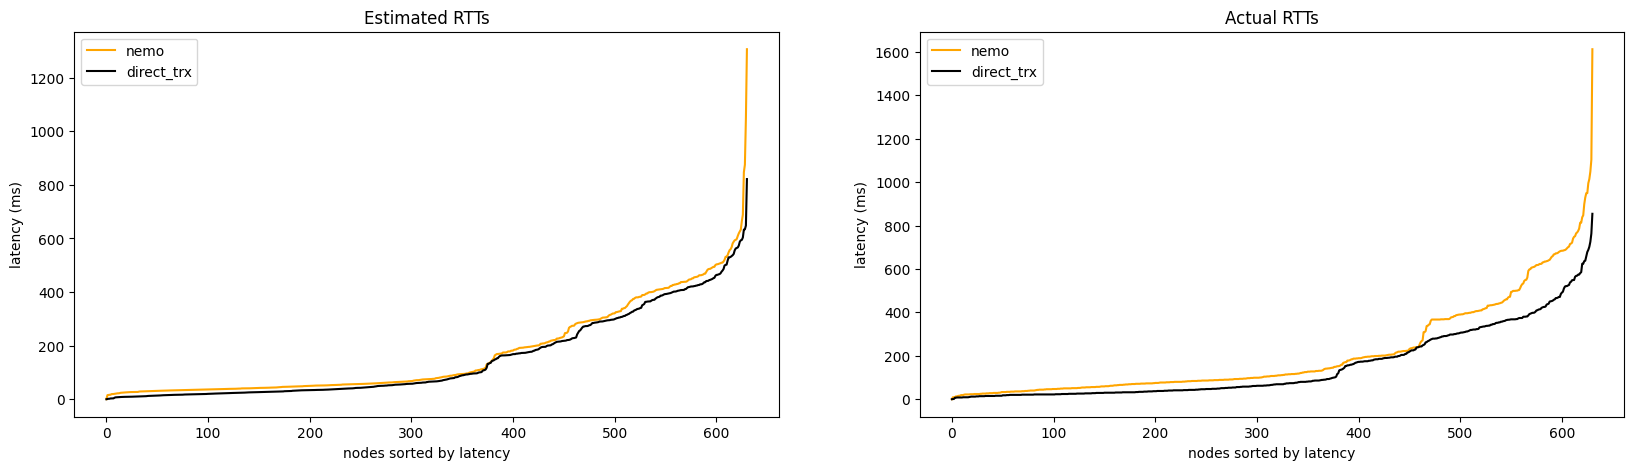

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=False)

sv_orig = edf["latency_distribution"].sort_values()
sv_orig.plot(ax=ax1, use_index=False, label="nemo", color="orange")

sv_direct_trx = coord_dict[0]["latency"].sort_values()
sv_direct_trx.plot(ax=ax1, use_index=False, label="direct_trx", color="black")

sv_rtt = edf2["latency_distribution"].sort_values()
sv_rtt.plot(ax=ax2, use_index=False, label="nemo", color="orange")

sv_rtt_direct_trx = df_rtt.loc[0].sort_values()
sv_rtt_direct_trx.plot(ax=ax2, use_index=False, label="direct_trx", color="black")

ax1.set_title('Estimated RTTs')
ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')
ax1.legend(loc="upper left", prop={'size': 10}, ncol=1)

ax2.set_title('Actual RTTs')
ax2.set_xlabel('nodes sorted by latency')
ax2.set_ylabel('latency (ms)')
ax2.legend(loc="upper left", prop={'size': 10}, ncol=1)

plt.show()

## Changing Topology

In [9]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight_1"

evaluations = []
evaluations_full = []
placement_df = None

for i, coords_df in enumerate(coord_list):
    df = prim_df.copy()
    df["x"] = coords_df["x"]
    df["y"] = coords_df["y"]
    df["latency"] = coords_df["latency"]
    df, centroids, opt_k, sil = topology.add_kmeans_labels(df, kmin=num_clusters, kmax=num_clusters, kseed=seed)
    
    eval_matrix, df_dict, opt_dict, limits_dict = evaluate_nemo(df, [slot_col], weight_col,
                                               merge_factor=param_dict[weight_col][
                                                   "merge_factor"],
                                               step_size=param_dict[weight_col]["step_size"],
                                               with_eval=True)
    if i == 0:
        placement_df = df_dict[slot_col].copy()
    
    if limits_dict[slot_col] == True:
        break
    
    evaluations_full.append(eval_matrix[slot_col])
    
    if i > 0:
        update_df = coords_df[["x", "y"]]
        df = util.update_coordinates(placement_df, update_df)
        edf = evaluate(df)
    else:
        edf = eval_matrix[slot_col]
    evaluations.append(edf)

Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  21
Evaluating for capacity_100
Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  20
Evaluating for capacity_100
Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  20
Evaluating for capacity_100
Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  20
Evaluating for capacity_100
Optimal k is 10
Starting nemo fo

## Evaluation

#### Latency

In [10]:
colors, light_colors, palette = util.get_color_list(11)

eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8],
    "nemo_dc_weight_2": colors[9],
    "nemo_dc_weight": colors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
}


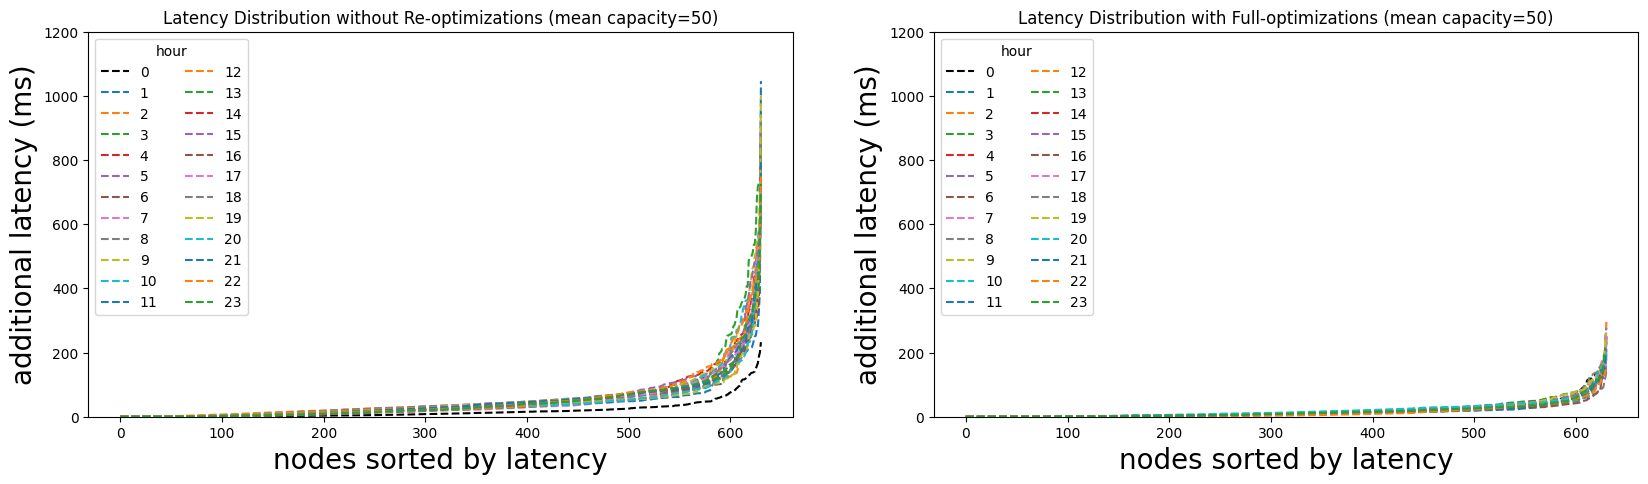

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=False)
quant_dict = {}
mean_dict = {}
prim_eval = coord_dict[t_label]["latency"]
nodes_take = 50
changed_nodes = {}

for i in range(len(evaluations)):
    l = str(i)
    sv1 = evaluations[i].sort_index()["latency_distribution"]
    sv2 = coord_list[i].sort_index()["latency"]
    sv = sv1 - sv2
    sv = sv.sort_values()
    
    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:]) # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--")
        
    sv1 = evaluations_full[i].sort_index()["latency_distribution"]
    sv = sv1 - sv2
    sv = sv.sort_values()
    
    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:]) # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('additional latency (ms)')
ax1.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")

ax2.set_xlabel('nodes sorted by latency')
ax2.set_ylabel('additional latency (ms)')
ax2.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")
# Display a figure.
# plt.ylim([0, 100])

ax1.set_ylim([0, 1200])
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)
ax2.yaxis.label.set_size(20)
ax2.xaxis.label.set_size(20)
ylim_orig = ax1.get_ylim()
ax2.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution without Re-optimizations (mean capacity=' + str(avg) + ")")
ax2.set_title('Latency Distribution with Full-optimizations (mean capacity=' + str(avg) + ")")
plt.show()

## Test Reoptimization

In [80]:
re_evaluations = []
ndf = prim_df.copy()
#i = 0
#ndf["x"] = coord_list[i]["x"]
#ndf["y"] = coord_list[i]["y"]
#ndf["latency"] = coord_list[i]["latency"]

nemo = NemoSolver(ndf, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                  merge_factor=param_dict[weight_col]["merge_factor"])
df, opts, limits = nemo.nemo_full()

edf = util.evaluate(df)
re_evaluations.append(edf)
print(df["oindex"].nunique())
df

Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  20
631


,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,308.494393,272.860026,coordinator,-1,<NA>,<NA>,<NA>,50,30,2,<NA>,20
1,1,316.976824,275.994535,worker,1,1,0,1,50,50,0,594,0
2,2,282.361038,258.647238,worker,1,1,0,1,50,50,0,570,0
3,3,306.501880,265.083892,worker,1,1,0,1,50,50,0,420,0
4,4,298.626985,272.848666,worker,1,1,0,1,50,10,1,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,626,306.716136,272.192946,worker,1,1,0,1,50,50,0,550,0
627,627,576.843206,381.661311,worker,7,1,0,1,50,50,0,551,0
628,628,435.369979,402.392926,worker,2,1,0,1,50,50,0,236,0
629,629,601.380349,374.773278,worker,7,1,0,1,50,50,0,551,0


In [81]:
df_re = df
k_neigh = 400
root_df = coord_list[0]

for i in range(1, len(evaluations)):
    nodes = changed_nodes[i]
    nodes = set(nodes).intersection(df_re["oindex"].unique())
    nodes = list(nodes)
    print("Iteration", i, "Nodes", nodes)
    update_df, centroids, opt_k, sil = topology.add_kmeans_labels(coord_list[i], kmin=num_clusters, kmax=num_clusters, kseed=seed)
    nemo.update_coordinates(update_df)
    df_re, opt_dict, resource_limit, level = nemo.remove_nodes(nodes, step_size=0.1, merge_factor=0.3)
    
    new_nodes = list()
    for node_idx in nodes:
        node = prim_df.loc[node_idx].to_dict()
        new_distances_df = coord_list[i]
        #n_coords, error = util.fit_coords(node_idx, root_df, new_distances_df, k_neigh)
        node["x"] = coord_list[i].loc[node_idx, "x"] #n_coords[0]
        node["y"] = coord_list[i].loc[node_idx, "y"] #n_coords[1]
        node["capacity"] = node[slot_col]
        node["weight"] = node[weight_col]
        node["oindex"] = node_idx
        new_nodes.append(node)
        # new_idx, df_re, resource_limit = nemo.add_node(node)
    df_re, opt_dict, resource_limit, level = nemo.add_nodes(new_nodes, full_opt=True, k_cluster_opt=4)
    if resource_limit:
        print("----------------Resource limit reached. Init full opt")
        df = prim_df.copy()
        coords_df = coord_list[i]
        
        df["x"] = coords_df["x"]
        df["y"] = coords_df["y"]
        df["latency"] = coords_df["latency"]
        df, centroids, opt_k, sil = topology.add_kmeans_labels(df, kmin=num_clusters, kmax=num_clusters, kseed=seed)
        
        nemo = NemoSolver(df, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                      merge_factor=param_dict[weight_col]["merge_factor"])
        df_re, opts, resource_limit = nemo.nemo_full()
        
        if resource_limit:
            print("Resource Limit!!!!!!!!!")
            break
    
    update_df = coord_list[i][["x", "y"]]
    df = util.update_coordinates(df_re, update_df)
    edf = evaluate(df)
    re_evaluations.append(edf)

Iteration 1 Nodes [256, 259, 517, 6, 137, 393, 396, 526, 528, 274, 21, 533, 280, 281, 153, 539, 285, 413, 287, 416, 164, 294, 167, 297, 299, 303, 437, 566, 316, 572, 451, 452, 326, 582, 585, 586, 206, 590, 339, 84, 90, 219, 223, 608, 226, 615, 490, 109, 241, 511]
Optimal k is 10
Node with ID [274, 533] are cluster head. Re-optimizing children with level 0: {0: [398, 399, 400, 401, 278, 407, 151, 541, 302, 469, 357, 114], 3: [545, 429, 595, 620], 6: [514, 579, 195, 606]}
Level 0 CH number:  20
re-optimizing clusters dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  18
Iteration 2 Nodes [256, 6, 393, 10, 396, 528, 530, 26, 538, 29, 543, 544, 418, 291, 419, 293, 295, 296, 297, 298, 302, 49, 306, 309, 438, 183, 437, 566, 446, 319, 447, 321, 450, 195, 76, 208, 84, 470, 90, 347, 219, 478, 606, 607, 226, 611, 231, 492, 116, 504]
Optimal k is 10
Node with ID [208, 470] are cluster head. Re-opt

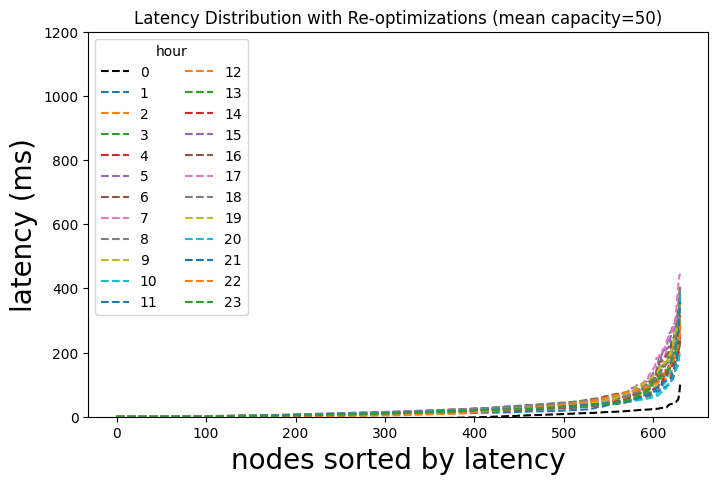

Means:  {'0': -13.47, '1': 26.35, '2': 22.56, '3': 25.38, '4': 22.79, '5': 26.24, '6': 28.08, '7': 23.67, '8': 28.73, '9': 24.93, '10': 22.91, '11': 16.8, '12': 26.42, '13': 29.68, '14': 21.78, '15': 32.39, '16': 24.59, '17': 31.62, '18': 29.73, '19': 27.64, '20': 20.87, '21': 22.52, '22': 23.19, '23': 22.69}
Quantiles:  {'0': 17.11, '1': 62.61, '2': 51.79, '3': 65.97, '4': 62.1, '5': 58.75, '6': 74.95, '7': 51.12, '8': 63.1, '9': 50.82, '10': 49.88, '11': 43.31, '12': 56.11, '13': 60.89, '14': 44.58, '15': 73.58, '16': 51.96, '17': 64.23, '18': 62.58, '19': 71.29, '20': 45.15, '21': 46.75, '22': 72.62, '23': 47.74}


In [82]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

for i in range(len(re_evaluations)):
    l = str(i)
    sv1 = re_evaluations[i].sort_index()["latency_distribution"]
    sv2 = coord_list[i].sort_index()["latency"]
    sv = (sv1 - sv2).dropna()
    sv = sv.sort_values()

    quant_dict[l] = round(sv.quantile(0.9), 2)
    mean_dict[l] = round(sv.mean(), 2)
    sv = sv.to_numpy()

    if i == 0:
        ax1.plot(sv, label=l, linestyle="--", color="black")
    else:
        ax1.plot(sv, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution with Re-optimizations (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)